# ===== FILE SETUP ======# 

In [1]:
import sys
sys.path.append("../") # go to parent dir

In [2]:
FILENAME="carbon_allocation/carbon_allocation_equations"
GIT_USER_NAME="SEI-DO3SE"
GIT_REPO_NAME="pyDO3SE"
BRANCH="carbon-allocation"
DEPENDENCIES=[
    
]

GCOLAB='google.colab' in str(get_ipython())

In [3]:
from IPython.display import Markdown as md
md(f"""
<a href="https://colab.research.google.com/github/{GIT_USER_NAME}/{GIT_REPO_NAME}/blob/{BRANCH}/notebooks/{FILENAME}.ipynb" target="_parent">
    <img src="https://colab.research.google.com/assets/colab-badge.svg"/>
</a>
""")


<a href="https://colab.research.google.com/github/SEI-DO3SE/pyDO3SE/blob/carbon-allocation/notebooks/carbon_allocation/carbon_allocation_equations.ipynb" target="_parent">
    <img src="https://colab.research.google.com/assets/colab-badge.svg"/>
</a>


In [4]:
#@title Download libraries from github
#@markdown Code Hidden
try:
    import importlib
    for name, path in DEPENDENCIES:
        importlib.import_module(name)
except ImportError:
    if GCOLAB:
        print('Running on CoLab')
        print("""
        This notebook requires access to private repositories. To access follow the steps below:
        1. Get an access key from your github account: https://docs.github.com/en/github/authenticating-to-github/creating-a-personal-access-token
        2. Save the key to a file in the following location on your google drive: `My Drive/access/collabaccess.txt`. The file should include your user on the first line and your token on the second.
        """)
        from google.colab import drive
        drive.mount('/content/drive')

        !mkdir -p ~/.access
        !cp "/content/drive/My Drive/access/collabaccess.txt" ~/.access/config
        import os
        creds = open(f'{os.path.expanduser("~")}/.access/config')
        creds_parsed = creds.read().splitlines()
        user, token = creds_parsed
        for name, path in DEPENDENCIES:
            !pip install git+https://{user}:{token}@{path}
        creds.close()
        creds = None
        creds_parsed = None

# ===== END OF FILE SETUP ======# 
----

# References
- Osborne et al 2015 - Jules Crop A parameterization
- Williams et al 2016 Evaluation of JULES-crop performance against site observations of
irrigated maize from Mead, Nebraska


# Import dependencies

In [5]:
# Dependencies
from math import exp
from matplotlib import pyplot as plt
from collections import namedtuple
import numpy as np
from functools import partial
import ipywidgets as widgets
from notebook_utils.widgets import *

# Calculating hourly accumulation of Net Primary Productivity(NPP) (net_prod)

""To simulate crop growth, net primary productivity (5) is accumulated over a day and then partitioned between five carbon pools: root (Croot), structural stem (Cstem), stem reserves
(Cresv), leaves (Cleaf), and harvested organs (Charv). The original formulation for 5 in JULES includes assumptions about
the sizes of the leaf, stem and root carbon pools in order to" Osborne et al 2015

In [6]:
# Carbon Pools
# These are calculated at the end of every day
c_root = 1 # root [kg C m^2]
c_stem = 1 # structural stem [kg C m^2]
c_resv = 1 # stem reserves [kg C m^2]
c_leaf = 1 # leaves [kg C m^2]
c_harv = 1 # harvested organs [kg C m^2]




rg=0.25 for all plant functional types in the original documentation for the JULES Vegetation Model part 2, it's stated just under eqn 41

Then for Rdc we have to scale up the dark respiration to represent the canopy (through either summing, or multiplying by a total LAI I guess??) It's described better in appendix 5 of this paper, equation A20 (https://gmd.copernicus.org/articles/10/1291/2017/gmd-10-1291-2017.pdf). There are two versions of getting Rd depending on the amount of CO2 flux per square meter of ground which is talked about, but not given as an equation, in the JULES Vegetation Model Part 2 paper where they talk about the different ways of considering canopy layers 'Light inhibition follows Mercado et al. (2007) when option 4 is used, while option 5 uses a 30% inhibition of leaf respiration at irradiance levels greater than 10 µmol quantam−2 s−1 (Atkin et al., 1997, 2000, 2006).' So 30% inhibition is where the 0.7 factor comes from in Appendix 5.

*Joanne Cook *

## Notes

If $ R_{dc} * \frac{c_{root}+c_{stem}}{c_{leaf}} > A_{canopy} $ then $A_{netprod} $ < 0

In [35]:
# **EQ 4** - Calculate the net primary productivity from canopy An
def calc_net_prod(
    A_can, # net canopy photosynthesis
    c_root, # root carbon pool
    c_stem, # stem carbon pool
    c_leaf, # leaf carbon pool
    R_dc, # rate of non-moisture-stessed canopy dark respiration TODO: Check we can get this from ewert eq
    r_g=0.25, # fraction of gross primary productivity less maintaenance respiration that is assigned to growth respiration
    beta: float = 1, # soil moisture dark respiration rate
):
    # Net primary productivity [gC m^-2 hour^-1]
    if c_leaf <= 0:
        return 0
    # net_prod = 0.012 * (1 - r_g) * (A_can - R_dc*((c_root + c_stem)/c_leaf))
    # return net_prod
    GPP = A_can + beta*R_dc
    
    # TODO: Below carbon ratio should be Nitrogen
    R_pm = R_dc * (beta + ((c_root + c_stem)/c_leaf))
    R_pg = r_g*(GPP - R_pm)

    R_p = R_pm + R_pg
    NPP = GPP - R_p
    return NPP

### Example day (NPP only)
"Net primary productivity is accumulated over a day and then divided into five crop components according to paritition coeff" Osborne et al 2015

In [8]:
# Example day
@widgets.interact
def run_day(
    # A_canopy = widgets.FloatSlider(min=0, max=100, step=0.1, value=20),
    c_root =widgets.FloatSlider(min=0, max=1, step=0.1, value=0.2),
    c_stem =widgets.FloatSlider(min=0, max=1, step=0.1, value=0.2),
    c_leaf =widgets.FloatSlider(min=0, max=1, step=0.1, value=0.2),
    r_g = widgets.FloatSlider(min=0, max=1, step=0.1, value=0.25),
    # R_dc = widgets.FloatSlider(min=0, max=1, step=0.1, value=0.32),
):
    
    def run_day(A_canopy):
        net_prod_acc = 0
        R_dc = A_canopy * 0.2
        for hr in range(24):
            net_prod_acc += calc_net_prod(
                A_canopy,
                c_root,
                c_stem,
                c_leaf,
                R_dc,
                r_g,
            )
        return net_prod_acc
    out = [run_day(a) for a in range(0,20)]
    plt.plot(out)
    # print("net prod acc at end of day: ", net_prod_acc)

interactive(children=(FloatSlider(value=0.2, description='c_root', max=1.0), FloatSlider(value=0.2, descriptio…

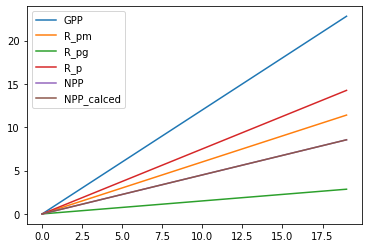

In [9]:
ac_range = np.array(list(range(20)))
Rdc_range = ac_range * 0.2
B = 1
r_g = 0.25

GPP_vals =[a + B*r for a, r in zip(ac_range, Rdc_range)]
R_pm_vals = [r * (B + (c_root + c_stem)/c_leaf) for r in Rdc_range]
R_pg_vals = [r_g * (g - r) for g, r in zip(GPP_vals, R_pm_vals)]
R_p_vals = [rm + rg for rm, rg in zip(R_pm_vals, R_pg_vals)]
NPP_vals = [g - r for g, r in zip(GPP_vals, R_p_vals)]

NPP_calced_vals = [calc_net_prod(
                A_canopy,
                c_root,
                c_stem,
                c_leaf,
                R_dc,
                r_g,
            ) for A_canopy, R_dc in zip(ac_range, Rdc_range)]


plt.plot(GPP_vals, label="GPP")
plt.plot(R_pm_vals, label="R_pm")
plt.plot(R_pg_vals, label="R_pg")
plt.plot(R_p_vals, label="R_p")
plt.plot(NPP_vals, label="NPP")
plt.plot(NPP_calced_vals, label="NPP_calced")
plt.legend()

# Distribution of carbon between pools
At the end of the day we distribute the carbon between the pools based on partition coefficients. These coefficients vary across the growing season as a function of thermal time since emergence.

In [10]:
# Calculations for these are below
p_root = 0.25 # partition coefficient for root
p_leaf = 0.25 # partition coefficient for leaf
p_stem = 0.25 # partition coefficient for stem
p_harv = 0.25 # partition coefficient for harv
pr_stem = 0.1 # fraction of stem carbon that is partitioned into reserve pool
assert p_root + p_leaf + p_stem + p_harv == 1.0

# EQ 5
def calc_carbon_pool_change(
    net_prod_acc, # acumulated net productivity
    p_root,  # partition coefficient for root
    p_leaf,  # partition coefficient for leaf
    p_stem,  # partition coefficient for stem
    p_harv,  # partition coefficient for harv
    pr_resv=0.4, # fraction of stem carbon that is partitioned into reserve pool - crop specific parameter
):
    Output = namedtuple('Output', 'c_root_diff c_leaf_diff c_stem_diff c_harv_diff c_resv_diff')
    c_root_diff = p_root * net_prod_acc
    c_leaf_diff = p_leaf * net_prod_acc
    c_stem_diff = p_stem * net_prod_acc * (1 - pr_resv)
    c_harv_diff = p_harv * net_prod_acc
    c_resv_diff = p_stem * net_prod_acc * pr_resv
    return Output(
        c_root_diff,
        c_leaf_diff,
        c_stem_diff,
        c_harv_diff,
        c_resv_diff,
    )

In [11]:
# Example
@widgets.interact(
    values = widgets.FloatRangeSlider(min=0, max=1, step=0.1, value=[0.2, 0.4]),
    p_harv = widgets.FloatSlider(min=0, max=1, step=0.1, value=0.2),
    pr_resv = widgets.FloatSlider(min=0, max=1, step=0.1, value=0.4),
)
def run_day(
    values,
    p_harv,
    pr_resv,
):
    p_root = values[0]/(1+p_harv)
    p_leaf = values[1]/(1+p_harv)
    p_root = (1-values[1])/(1+p_harv)
    p_harv = p_harv/(1+p_harv)
    print(
        f"""
        p_root={p_root}
        p_leaf={p_leaf}
        p_root={p_root}
        p_harv={p_harv}
        """
    )
    x = np.arange(0,100)
    diff_results = calc_carbon_pool_change(net_prod_acc=20, p_root=p_root, p_leaf=p_leaf, p_stem=p_stem, p_harv=p_harv, pr_resv=pr_resv)

    plt.bar(["20"], height=diff_results.c_root_diff, width=0.35, label="c_root_diff", bottom=diff_results.c_leaf_diff)
    plt.bar(["20"], height=diff_results.c_leaf_diff, width=0.35, label="c_leaf_diff", bottom=diff_results.c_stem_diff)
    plt.bar(["20"], height=diff_results.c_stem_diff, width=0.35, label="c_stem_diff", bottom=diff_results.c_harv_diff)
    plt.bar(["20"], height=diff_results.c_harv_diff, width=0.35, label="c_harv_diff", bottom=diff_results.c_resv_diff)
    plt.bar(["20"], height=diff_results.c_resv_diff, width=0.35, label="c_resv_diff", bottom=0)
    
    
    plt.xlabel("net_prod_acc")
    plt.legend()
    plt.show()

interactive(children=(FloatRangeSlider(value=(0.2, 0.4), description='values', max=1.0), FloatSlider(value=0.2…

# Define partition coefficients based on DVI and cultivar parameters
"
Here we define the partition coefficients as a function of
thermal time using six parameters to describe continuously
varying partition coefficients over the duration of the crop
cycle" Osborne et al 2015

In [12]:
# Check Osborne et al 2015 for actual values in table 4

# Set for wheat
cultivars = ["Wheat", "Soybean", "Maize", "Rice"]

parameters = {
    "Wheat": {
        "a_root": 18.5, # Param
        "a_stem": 16.0, # Param
        "a_leaf": 18.0, # Param
        "b_root": -20.0, # Param
        "b_stem": -15.0, # Param
        "b_leaf": -18.5, # Param
    },
    "Soybean": {
        "a_root": 20.0, # Param
        "a_stem": 18.5, # Param
        "a_leaf": 19.5, # Param
        "b_root": -16.5, # Param
        "b_stem": -14.5, # Param
        "b_leaf": -15.0, # Param
    },
    "Maize": {
        "a_root": 13.5, # Param
        "a_stem": 12.5, # Param
        "a_leaf": 13.0, # Param
        "b_root": -15.5, # Param
        "b_stem": -12.5, # Param
        "b_leaf": -14.0, # Param
    },
    "Rice": {
        "a_root": 18.5, # Param
        "a_stem": 19.0, # Param
        "a_leaf": 19.5, # Param
        "b_root": -19.0, # Param
        "b_stem": -17.0, # Param
        "b_leaf": -18.5, # Param
    },
}

In [13]:
# EQ 6
def calc_partition_coefficients(
    DVI, # -1 -> 2
    a_root,
    a_leaf,
    a_stem,
    b_root,
    b_leaf,
    b_stem,
):
    Output = namedtuple('Output', 'p_root p_leaf p_stem p_harv')
    bottom_of_eq = exp(a_root + (b_root*DVI)) + exp(a_stem + (b_stem * DVI)) + exp(a_leaf + (b_leaf*DVI)) + 1
    p_root  = (exp(a_root + (b_root * DVI))) / bottom_of_eq
    p_leaf  = (exp(a_leaf + (b_leaf * DVI))) / bottom_of_eq
    p_stem  = (exp(a_stem + (b_stem * DVI))) / bottom_of_eq
    p_harv  = 1 / bottom_of_eq
    return Output(p_root, p_leaf, p_stem, p_harv)

calc_partition_coefficients(
    0, 
        a_root= 18.5, # Param
        a_stem= 16.0, # Param
        a_leaf= 18.0, # Param
        b_root= -20.0, # Param
        b_leaf= -15.0, # Param
        b_stem= -18.5, # Param
)

Output(p_root=0.5922010669465662, p_leaf=0.3591881038176261, p_stem=0.04861082376538027, p_harv=5.470427545684183e-09)

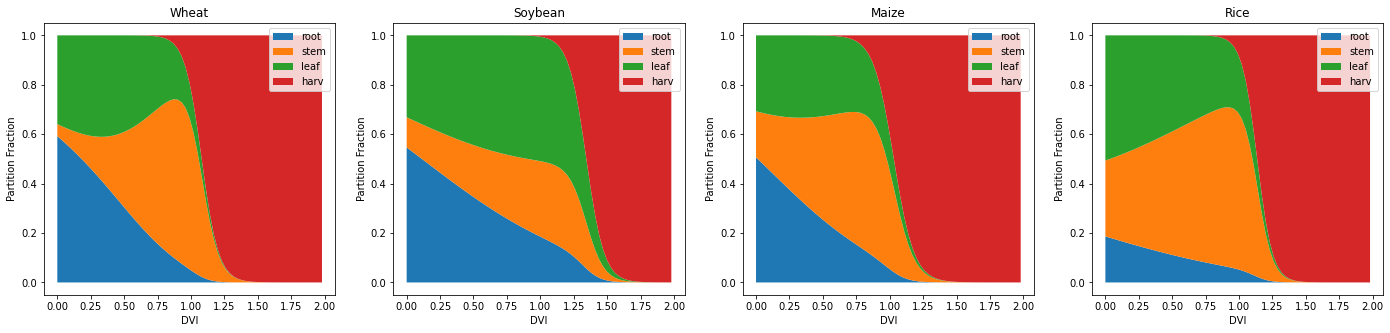

In [14]:
# plot relationships between dvi and partitions as in Figure 2
def plot_cultivar(cultivar, ax, **params):
    x = np.arange(0,2, 3/100)
    zeros = np.zeros(x.shape)
    results =list(map(partial(calc_partition_coefficients, **params), x))
    p_root_results = np.array(list(map(lambda o: o.p_root, results)))
    p_stem_results = np.array(list(map(lambda o: o.p_stem, results))) + p_root_results
    p_leaf_results = np.array(list(map(lambda o: o.p_leaf, results))) + p_stem_results
    p_harv_results = np.array(list(map(lambda o: o.p_harv, results))) + p_leaf_results
    ax.fill_between(x, zeros, p_root_results, label="root")
    ax.fill_between(x, p_root_results, p_stem_results, label="stem")
    ax.fill_between(x, p_stem_results, p_leaf_results, label="leaf")
    ax.fill_between(x, p_leaf_results, p_harv_results, label="harv")
    ax.set_title(cultivar)
    ax.set_xlabel("DVI")
    ax.set_ylabel("Partition Fraction")
    ax.legend()
fig, axs = plt.subplots(ncols=len(cultivars), figsize=(24, 5))
for i, cultivar in enumerate(cultivars):
    plot_cultivar(cultivar, axs[i], **parameters[cultivar])



In [15]:
@widgets.interact(
    a_root= widgets.FloatSlider(value=18.5, min=17.5, max=19.5), # Param
    a_leaf= widgets.FloatSlider(value=18.0, min=17.0, max=19.0), # Param
    a_stem= widgets.FloatSlider(value=16.0, min=15.0, max=17.0), # Param
    b_root= widgets.FloatSlider(value=-20.0, min=-21.0, max=-19.0), # Param
    b_leaf= widgets.FloatSlider(value=-18.5, min=-19.5, max=-17.5), # Param
    b_stem= widgets.FloatSlider(value=-15.0, min=-16.0, max=-14.0), # Param
)
def plot_interactive(
    a_root,
    a_leaf,
    a_stem,
    b_root,
    b_leaf,
    b_stem,
):
    fig, ax = plt.subplots(ncols=1)
    plot_cultivar("Interactive", ax, 
    a_root=a_root,
    a_leaf=a_leaf,
    a_stem=a_stem,
    b_root=b_root,
    b_leaf=b_leaf,
    b_stem=b_stem,
    )

interactive(children=(FloatSlider(value=18.5, description='a_root', max=19.5, min=17.5), FloatSlider(value=18.…

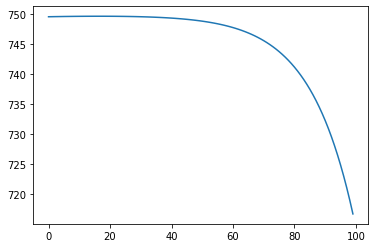

In [16]:
x = np.arange(0,2, 2/100)
zeros = np.zeros(x.shape)
results =list(map(partial(calc_partition_coefficients, **parameters['Wheat']), x))
p_root_results = np.array(list(map(lambda o: o.p_root, results)))
p_stem_results = np.array(list(map(lambda o: o.p_stem, results)))
p_leaf_results = np.array(list(map(lambda o: o.p_leaf, results)))
p_harv_results = np.array(list(map(lambda o: o.p_harv, results)))
results_anet = [calc_net_prod(
    A_can = 1000,
    c_root=o.p_root,
    c_stem=o.p_stem,
    c_leaf=o.p_leaf,
    r_g=0.25,
    R_dc=0.32,  # yscale
) for o in results]
plt.plot(results_anet)

# Carbon pool distributions near end of plant life
"...once carbon is no longer partitioned to stems, carbon from the
stem reserve pool is mobilised to the harvest pool at a rate
of 10 % a day" Osborne et al 2015

In [17]:
# EQ 7
if p_stem < 0.01:
    c_harv = c_harv + 0.1 * c_resv
    c_resv = 0.9 * c_resv


"Leaf senescence is treated simplistically by mobilising
carbon from the leaf to the harvest pool at a rate of 0.05 d−1
once DVI has reached 1." Osborne et al 2015

In [18]:
# EQ 8
DVI = 1.8 # example dvi
if DVI > 1.5:
    c_harv = c_harv + 0.05 * c_leaf
    c_leaf = 0.95 * c_leaf    

# Carbon pool to Leaf Area Index (LAI)
"
At the end of each growth time step (24 h), the amount of
carbon in the leaves is related to leaf area index" Osborne et al 2015

In [19]:
# EQ 9 and 10
# Cultivar specific parameters from table 4
# Wheat

def calc_LAI_from_DVI_and_carbon(
    DVI,
    c_leaf,
    gamma = 27.3, # Crop specific Param
    delta = -0.0507, # Crop specific Param
    f_c = 0.5, # Const
):
    if DVI<= -0.06:
        return 0
    SLA = gamma * (DVI + 0.06) ** delta
    LAI = (c_leaf / f_c) * SLA
    return LAI



In [20]:
# Example
@widgets.interact
def run(
   c_leaf=widgets.FloatSlider(min=0, max=1, step=0.1, value=1),
    gamma=widgets.FloatSlider(min=10, max=30, step=0.1, value=27.3),
    delta=widgets.FloatSlider(min=-0.4, max=0, step=0.01, value=-0.0507),
):
    x = np.arange(-1,2,3/100)
    results = list(map(partial(calc_LAI_from_DVI_and_carbon, c_leaf=c_leaf, gamma=gamma, delta=delta), x))
    plt.plot(x, results)
    plt.show()

interactive(children=(FloatSlider(value=1.0, description='c_leaf', max=1.0), FloatSlider(value=27.3, descripti…

# Carbon to plant height
"The amount of carbon in the stem is related to the crop
height by (Hunt, 1990)"

In [21]:
# Parameters cultivar specific from table 4
def get_plant_height_from_carbon(
    c_stem,
    lambdav = 0.4, # Param same for all cultivars in table 4
    k = 1.4, # Param
    f_c = 0.5, # Const
):
    height = k * (c_stem / f_c) ** lambdav
    return height

In [22]:
# Example
@widgets.interact
def run(
    k=widgets.FloatSlider(min=1, max=4, step=0.1, value=1.4),
):
    x = np.arange(0,100,1)
    results = list(map(partial(get_plant_height_from_carbon, k=k), x))
    plt.plot(x, results)
    plt.show()

interactive(children=(FloatSlider(value=1.4, description='k', max=4.0, min=1.0), Output()), _dom_classes=('wid…

# Fraction of roots from Root Carbon
"Because root biomass increases during the crop growing
season the fraction of roots in each JULES soil layer varies
according to the equation of Arora and Boer (2003) which
defines the fraction of roots at depth z a" Osborne et al

In [23]:
# Eq 12 and 13
def calc_root_fraction_from_carbon(
    c_root,
    d_r = 0.5, # Param - for all crop types
    # TODO: Check this is meant to be 0.0 for all params
    r_dir = 0.0, # Param - Crop specific table 4(Actually 0.0 for all crops!)
    z = 0.5, # Root depth
    f_c = 0.5,
):
    a = d_r * (c_root/f_c) ** r_dir
    f = 1 - exp(-z/a)
    return f


In [24]:
# Example
@widgets.interact
def run(
    z=widgets.FloatSlider(min=0, max=4, step=0.1, value=0.5),
    r_dir=widgets.FloatSlider(min=0, max=4, step=0.1, value=0),
):
    x = np.arange(0,100,1)
    results = list(map(partial(calc_root_fraction_from_carbon, z=z,r_dir=r_dir), x))
    plt.plot(x, results)
    plt.show()

interactive(children=(FloatSlider(value=0.5, description='z', max=4.0), FloatSlider(value=0.0, description='r_…

# Sowing and growing season
"To ensure crop establishment, the growing season is curtailed if the sum of root, leaf, stem and reserve carbon falls below the initial seed carbon content (or zero carbon content)
if the sowing date is determined dynamically" Osborne et al

# Linking Together

In [25]:
hrs = [hr for dd in range(365) for hr in range(24)]
dd_hourly = [dd for dd in range(365) for hr in range(24)]
dd_daily = [dd for dd in range(365)]

In [59]:
def umol_c_to_kg_c(val: float) -> float:
    """Convert from umols per s of carbon to kg per hour of carbon.

    Parameters
    ----------
    val : float
        input

    Returns
    -------
    float
        output
    """
    UMOL_TO_MOL = 1e-6
    MOL_TO_G = 12
    S_TO_H = 3600
    G_TO_KG = 1e-3
    return val * UMOL_TO_MOL * MOL_TO_G * S_TO_H * G_TO_KG


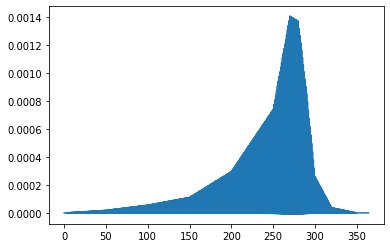

In [60]:
# Generate Anet data
# Taken from Winter Wheat Oklahoma graph
x = [0,50,100,150,200,250,270, 280, 290,300,320,350]
y= [0,0.5,1.5,3,8,20,38, 37, 23,7,1,0]

a = 1

hourly_profile = np.array([-2.49E-04,-2.77E-04,-2.63E-04,-2.43E-04,-2.47E-04,-2.45E-04,-4.27E-04,3.91E-02,5.07E-02,1.04E-01,8.43E-02,9.66E-02,1.07E-01,1.06E-01,1.06E-01,9.41E-02,1.03E-01,9.91E-02,1.42E-02,-5.46E-04,-4.93E-04,-3.43E-04,-4.08E-04,-3.74E-04,
])*8
# convert from umol to grams and seconds to hours
anet_daily_max = np.interp(dd_daily, x, y)
anet_hourly = [umol_c_to_kg_c(a*hm) for a in anet_daily_max for hm in hourly_profile]
# plt.plot(x, y)
plt.plot(dd_hourly, anet_hourly)

In [61]:
sum(anet_hourly)

0.9158262623999999

In [62]:
np.savetxt("ancanopy_data.csv", anet_hourly)

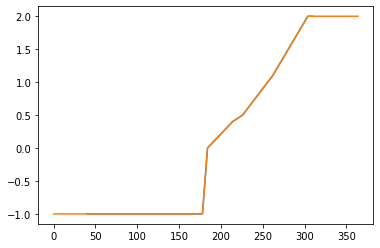

In [63]:
# Generate DVI data
a = -100
b = 0.6
x = b*np.array([a,129,130,140,190,210, 230, 270, 340,341,342,350]) - a
# x = [0,50,80,150,200,300,340, 350, 351,352, 353,354]
y= np.array([-1.001,-1.001,-0.99,0.0,0.4,0.5,0.7, 1.1, 2,2,2,2])
# y= [0.0,0.2,0.3,0.7, 1.1, 2,2,2,2, 2, 2, 2]
dvi_hourly = np.interp(dd_hourly, x, y)
plt.plot(x, y)
plt.plot(dd_hourly, dvi_hourly)

In [64]:
params = {
    "wheat": {
            "a_root": 18.5, # Param
            "a_stem": 16.0, # Param
            "a_leaf": 18.0, # Param
            "b_root": -20.0, # Param
            "b_stem": -15.0, # Param
            "b_leaf": -18.5, # Param
            "gamma": 27.3,
            "delta": -0.0507,
            "r_g": 0.1, # TODO: Check this value
            "R_dc": 0.22, # TODO: Check this value
            "pr_resv": 0.4,
            "k": 1.4,
    },
    "soybean": {
            "a_root": 20.0, # Param
            "a_stem": 18.5, # Param
            "a_leaf": 19.5, # Param
            "b_root": -16.5, # Param
            "b_stem": -14.5, # Param
            "b_leaf": -15.0, # Param
            "gamma": 25.9,
            "delta": -0.1451,
            "r_g": 0.1, # TODO: Check this value
            "R_dc": 0.32, # TODO: Check this value
            "pr_resv": 0.18,
            "k": 1.6,
    }
}
cultivar = "wheat"

In [65]:
# State
ModelState = namedtuple('ModelState', [
    "c_root",
    "c_stem",
    "c_leaf",
    "c_harv",
    "c_resv",
    "net_prod_acc",
    "lai",
    "plant_height",
    "p_root",
    "p_leaf",
    "p_stem",
    "p_harv",
])
# Parameters

# Initial state
model_state = ModelState(
    c_root=0,
    c_stem=0,
    c_leaf=0,
    c_harv = 0,
    c_resv = 0,
    net_prod_acc=0,
    lai=0,
    plant_height=0,
    p_root=0,
    p_leaf=0,
    p_stem=0,
    p_harv=0,
)


In [66]:
logs = []
init_carbon = 8e-4
has_emerged = False
cparams = params[cultivar]
for dd in range(365):
    net_prod_acc = 0
    for hr in range(24):
        row_index = (dd*24) + hr
        DVI = dvi_hourly[row_index]
        An_canopy = anet_hourly[row_index]
        net_prod_acc += calc_net_prod(
            An_canopy,
            model_state.c_root,
            model_state.c_stem,
            model_state.c_leaf,            
            umol_c_to_kg_c(cparams["R_dc"]),
            cparams["r_g"],
        )
    # == End of day ==
    if has_emerged:
        net_prod_acc = max(0, net_prod_acc)
    else:
        net_prod_acc = init_carbon

    if DVI > 0.0:
        has_emerged = True
    
    (p_root, p_leaf, p_stem, p_harv)= calc_partition_coefficients(
        DVI if DVI > 0 else 0, # -1 -> 2
        cparams["a_root"],
        cparams["a_leaf"],
        cparams["a_stem"],
        cparams["b_root"],
        cparams["b_leaf"],
        cparams["b_stem"],
    )

    (
        c_root_diff,
        c_leaf_diff,
        c_stem_diff,
        c_harv_diff,
        c_resv_diff
    ) = calc_carbon_pool_change(
        net_prod_acc, # acumulated net productivity
        p_root,  # partition coefficient for root
        p_leaf,  # partition coefficient for leaf
        p_stem,  # partition coefficient for stem
        p_harv,  # partition coefficient for harv
        cparams["pr_resv"],
    )
    
    if DVI>0:
        c_root = max(0, model_state.c_root + c_root_diff)
        c_stem = max(0, model_state.c_stem + c_stem_diff)
        c_leaf = max(0, model_state.c_leaf + c_leaf_diff)
        c_harv = max(0, model_state.c_harv + c_harv_diff)
        c_resv = max(0, model_state.c_resv + c_resv_diff)
    elif DVI > -1:
        c_root = c_root_diff
        c_stem = c_stem_diff
        c_leaf = c_leaf_diff
        c_harv = c_harv_diff
        c_resv = c_resv_diff
    else: 
        c_root = 0
        c_stem = 0
        c_leaf = 0
        c_harv = 0
        c_resv = 0

    if p_stem < 0.01:
        c_harv = c_harv + 0.1 * c_resv
        c_resv = 0.9 * c_resv

    if DVI > 1.5:
        c_harv = c_harv + 0.05 * c_leaf
        c_leaf = 0.95 * c_leaf  
    
        
    lai = calc_LAI_from_DVI_and_carbon(
        DVI,
        c_leaf,
        gamma = cparams["gamma"], # Param
        delta = cparams["delta"], # Param
        f_c = 0.5, # Const
    )

    plant_height = get_plant_height_from_carbon(
        c_stem,
        lambdav = 0.4, # Param same for all cultivars in table 4
        k = cparams["k"], # Param
        f_c = 0.5, # Const
    )
    # ) if 2>DVI>0 else 0
   
    model_state = ModelState(
        c_root = c_root,
        c_stem = c_stem,
        c_leaf = c_leaf,
        c_harv = c_harv,
        c_resv = c_resv,
        net_prod_acc=net_prod_acc,
        lai=lai,
        plant_height=plant_height,
        p_root=p_root,
        p_leaf=p_leaf,
        p_stem=p_stem,
        p_harv=p_harv,
    )
    logs.append(model_state)

logs[-1]


ModelState(c_root=0.07362705263701191, c_stem=0.08771306043180878, c_leaf=0.001278598185913319, c_harv=0.49139242748539047, c_resv=4.458578023338222e-06, net_prod_acc=0, lai=0.06729978217142409, plant_height=0.6978558761102549, p_root=4.5990515265262127e-10, p_leaf=5.602791744686968e-09, p_stem=8.315280226228297e-07, p_harv=0.9999991624092804)

In [67]:
# Totals
# Calc crop yield per sqm
crop_yield = model_state.c_harv * 2  * 1.16 * 10
print(f"yield :{crop_yield}")

# Total NPP
total_NPP = sum([o.net_prod_acc for o in logs])
print(f"total npp: {total_NPP} [kg C m^-2]")

yield :11.400304317661059
total npp: 0.8012155973181474 [kg C m^-2]


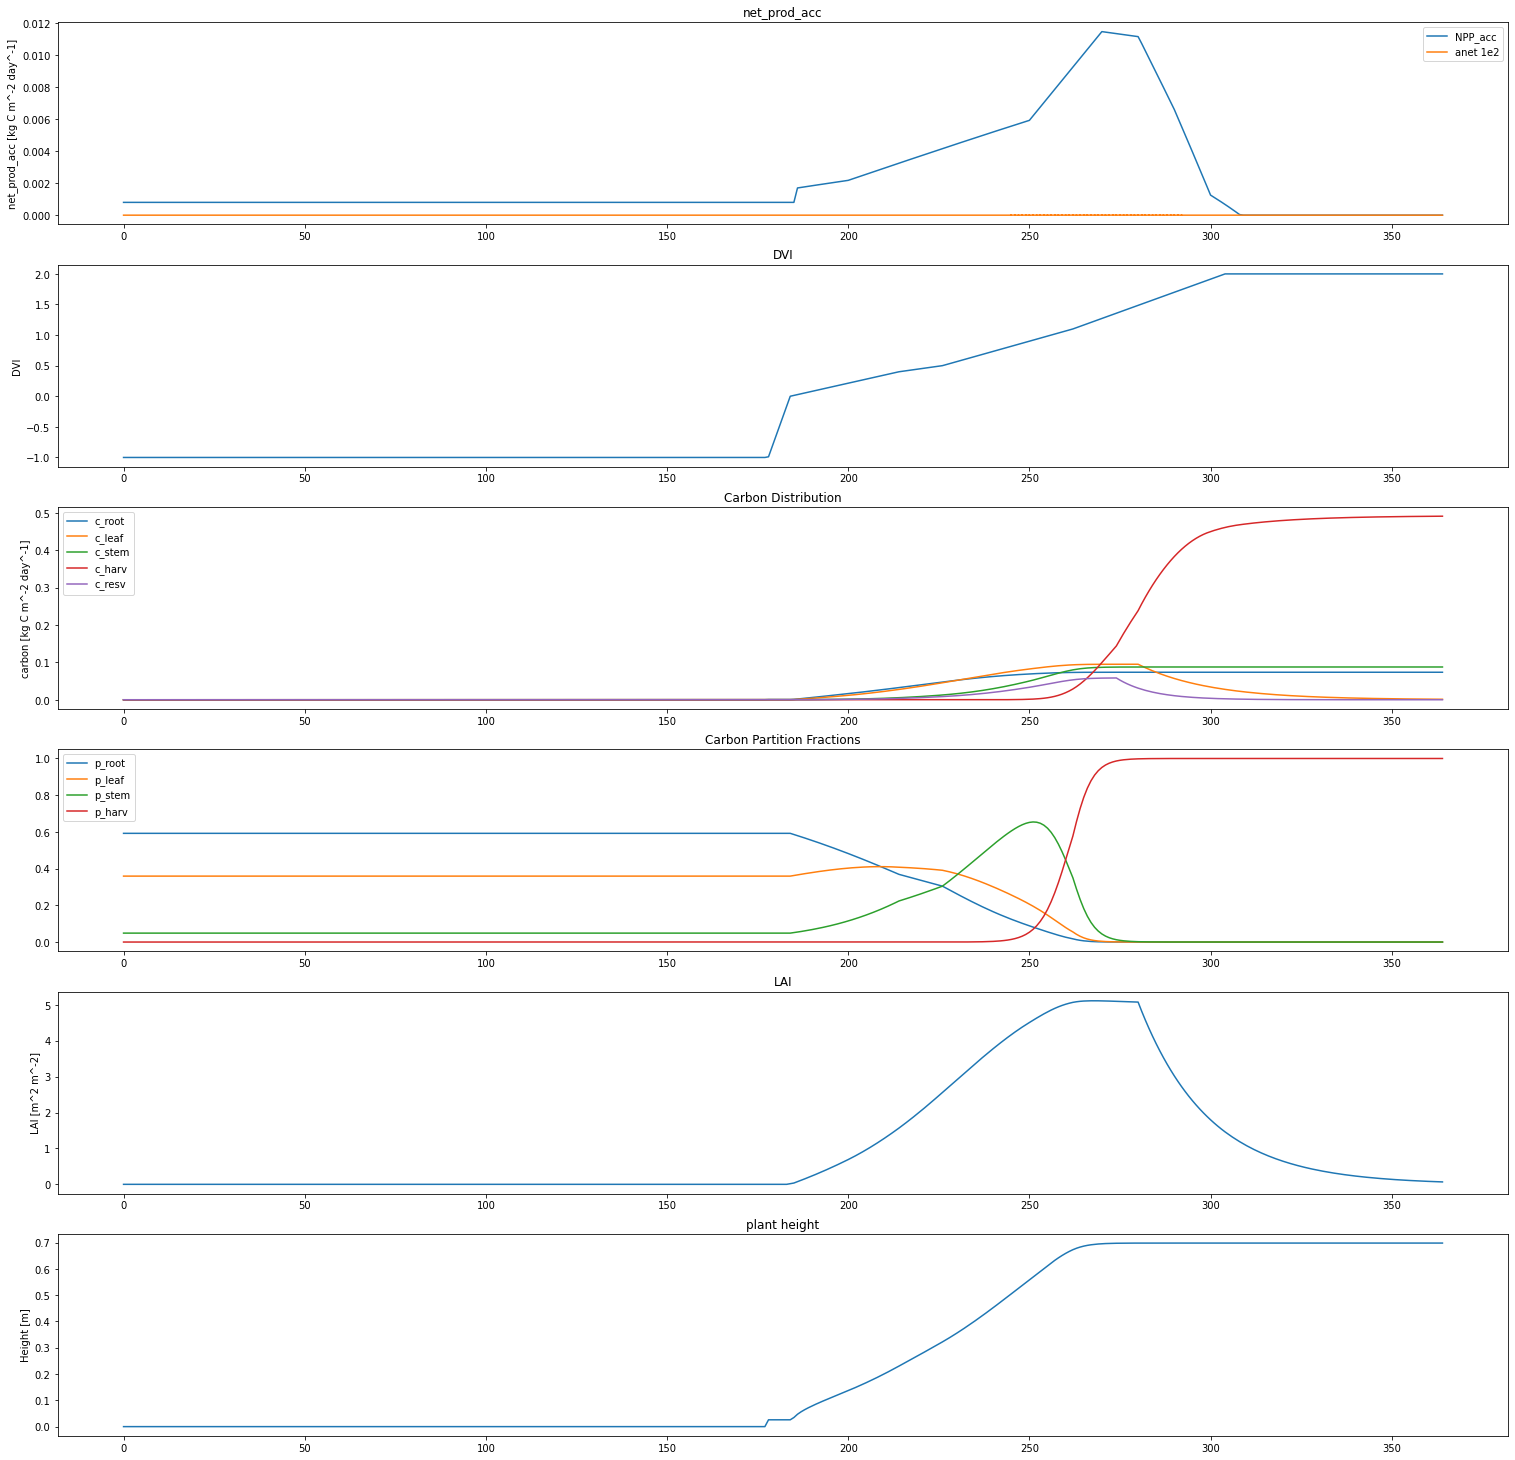

In [68]:
def draw_plots(output_logs):
    fig, axs = plt.subplots(ncols=1, nrows=6, figsize=(26,26))

    # Draw net_prod
    axs[0].plot(list(map(lambda o: o.net_prod_acc, output_logs)), label="NPP_acc")
    axs[0].plot(dd_hourly, np.array(anet_hourly) / 100, label="anet 1e2")
    axs[0].set_title("net_prod_acc")
    axs[0].legend()
    axs[0].set_ylabel("net_prod_acc [kg C m^-2 day^-1]")
    
    # DVI
    axs[1].plot(dd_hourly, dvi_hourly)
    axs[1].set_title("DVI")
    axs[1].set_ylabel("DVI")

    # Carbon Pools
    axs[2].plot(list(map(lambda o: o.c_root, output_logs)), label="c_root")
    axs[2].plot(list(map(lambda o: o.c_leaf, output_logs)), label="c_leaf")
    axs[2].plot(list(map(lambda o: o.c_stem, output_logs)), label="c_stem")
    axs[2].plot(list(map(lambda o: o.c_harv, output_logs)), label="c_harv")
    axs[2].plot(list(map(lambda o: o.c_resv, output_logs)), label="c_resv")
    axs[2].set_ylabel("carbon [kg C m^-2 day^-1]")
    axs[2].set_title("Carbon Distribution")
    axs[2].legend()

    # Carbon Partitions
    axs[3].plot(list(map(lambda o: o.p_root, output_logs)), label="p_root")
    axs[3].plot(list(map(lambda o: o.p_leaf, output_logs)), label="p_leaf")
    axs[3].plot(list(map(lambda o: o.p_stem, output_logs)), label="p_stem")
    axs[3].plot(list(map(lambda o: o.p_harv, output_logs)), label="p_harv")
    axs[3].set_title("Carbon Partition Fractions")
    axs[3].legend()

    # LAI
    axs[4].plot(list(map(lambda o: o.lai, logs)), label="lai")
    axs[4].set_ylabel("LAI [m^2 m^-2]")
    axs[4].set_title("LAI")

    # Height
    axs[5].plot(list(map(lambda o: o.plant_height, logs)), label="plant_height")
    axs[5].set_ylabel("Height [m]")
    axs[5].set_title("plant height")
draw_plots(logs)

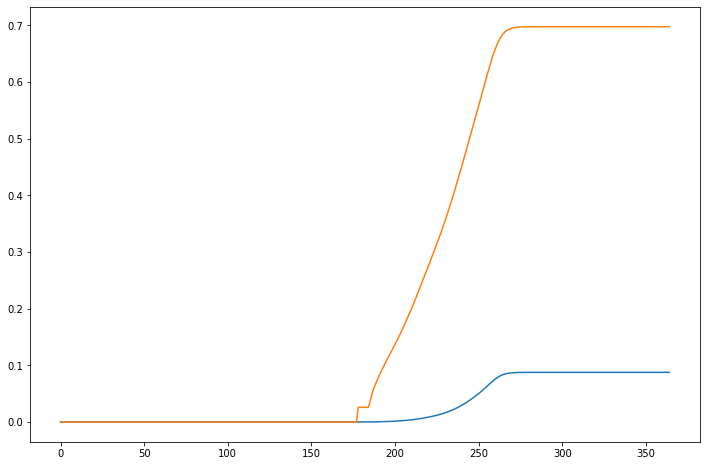

In [69]:

plt.figure(figsize=(12,8))
plt.plot(list(map(lambda o: o.c_stem, logs)), label="c_stem")
plt.plot(list(map(lambda o: o.plant_height, logs)), label="plant_height")


In [ ]:
stem_data = list(map(lambda o: o.c_stem, logs))
height_data = list(map(lambda o: o.plant_height, logs))
plt.plot(stem_data[161:200])
plt.plot(np.array(height_data[161:200])/100)

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(list(map(lambda o: o.c_root, logs)), label="c_root")
plt.plot(list(map(lambda o: o.c_leaf, logs)), label="c_leaf")
plt.plot(list(map(lambda o: o.c_stem, logs)), label="c_stem")
plt.plot(list(map(lambda o: o.c_harv, logs)), label="c_harv")
plt.plot(list(map(lambda o: o.c_resv, logs)), label="c_resv")
plt.xlabel("days")
plt.ylabel("carbon")
plt.legend()
plt.title ="Carbon Distribution"
plt.show()

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(list(map(lambda o: o.p_root, logs)), label="p_root")
plt.plot(list(map(lambda o: o.p_leaf, logs)), label="p_leaf")
plt.plot(list(map(lambda o: o.p_stem, logs)), label="p_stem")
plt.plot(list(map(lambda o: o.p_harv, logs)), label="p_harv")
plt.legend()

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(list(map(lambda o: o.lai, logs)), label="lai")
plt.title="LAI"

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(list(map(lambda o: o.plant_height, logs)), label="plant_height")
plt.title="plant height"
plt.legend()
logs[-1].plant_height

# Validating Results

## Papers
- Osborne et al 2015
- Verma et al., 2005



In [ ]:

# == End of day ==
# net_prod_acc = max(0, net_prod_acc)
net_prod_acc = 1.2
# net_prod_acc = 0.3 # Const alt
DVI=1.8
(p_root, p_leaf, p_stem, p_harv)= calc_partition_coefficients(
    DVI, # -1 -> 2
    cparams["a_root"],
    cparams["a_leaf"],
    cparams["a_stem"],
    cparams["b_root"],
    cparams["b_leaf"],
    cparams["b_stem"],
)

(
    c_root_diff,
    c_leaf_diff,
    c_stem_diff,
    c_harv_diff,
    c_resv_diff
) = calc_carbon_pool_change(
    net_prod_acc, # acumulated net productivity
    p_root,  # partition coefficient for root
    p_leaf,  # partition coefficient for leaf
    p_stem,  # partition coefficient for stem
    p_harv,  # partition coefficient for harv
    cparams["pr_resv"],
)
print(
     c_root_diff,
 c_leaf_diff,
 c_stem_diff,
 c_harv_diff,
 c_resv_diff
)

if DVI>0:
    c_root = max(0, model_state.c_root + c_root_diff)
    c_stem = max(0, model_state.c_stem + c_stem_diff)
    c_leaf = max(0, model_state.c_leaf + c_leaf_diff)
    c_harv = max(0, model_state.c_harv + c_harv_diff)
    c_resv = max(0, model_state.c_resv + c_resv_diff)
elif DVI > -1:
    c_root = c_root_diff
    c_stem = c_leaf_diff
    c_leaf = c_stem_diff
    c_harv = c_harv_diff
    c_resv = c_resv_diff
else: 
    c_root = 0
    c_stem = 0
    c_leaf = 0
    c_harv = 0
    c_resv = 0

if p_stem < 0.01:
    c_harv = c_harv + 0.1 * c_resv
    c_resv = 0.9 * c_resv

if DVI > 1.5:
    c_harv = c_harv + 0.05 * c_leaf
    c_leaf = 0.95 * c_leaf  

    
lai = calc_LAI_from_DVI_and_carbon(
    DVI,
    c_leaf,
    gamma = cparams["gamma"], # Param
    delta = cparams["delta"], # Param
    f_c = 0.5, # Const
)

plant_height = get_plant_height_from_carbon(
    c_stem,
    lambdav = 0.4, # Param same for all cultivars in table 4
    k = cparams["k"], # Param
    f_c = 0.5, # Const
)
plant_height, lai